# Projection on vertical modes

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import crocosi.postp as pp
from crocosi.gridop import get_z, N2Profile
import crocosi.gridop as gp

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44347 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 21.47 GB


# Read netcdf file

In [3]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp9_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams)

# Compute vertical modes

**ssh temporal mean**

<xarray.DataArray 'ssh_a' (y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(722, 258), dtype=float32, chunksize=(722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    f        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


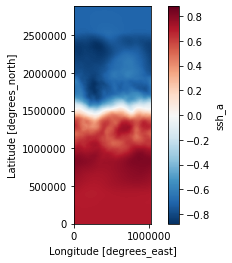

In [4]:
# eventually should also average along x
sshmean = r['his'].ssh_a.mean(dim='time').persist()
print(sshmean)
p = sshmean.plot(x='xi_rho',y='eta_rho')
p.axes.set_aspect('equal')

**Compute z mean from ssh mean**

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:109: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


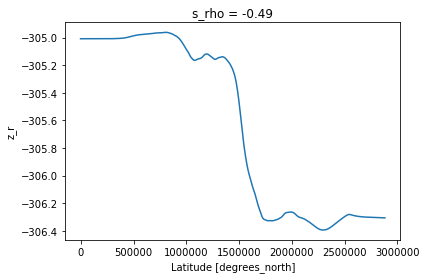

In [5]:
zmean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='r', hgrid='r')
#zmean.isel(x_rho=125).plot(x='y_rho', y='s_rho')
zmean.isel(x_rho=125).sel(s_rho=-.5, method='nearest').plot(x='eta_rho')

**Interpolate vertically stratification T(x,y,z,t)  on zmean -> T(x,y,$\bar{z}$,t)**

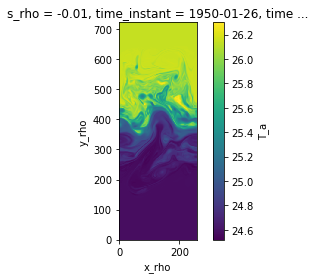

In [6]:
p = r['his'].T_a.isel(time=0,s_rho=-1).plot()
p.axes.set_aspect('equal')

In [7]:
z = get_z(r, zeta=r['his'].ssh_a, h=r['his'].h, vgrid='r', hgrid='r')
T = r['his'].T_a.chunk({'s_rho':None})

In [8]:
z

<xarray.DataArray 'z_r' (time: 12, y_rho: 722, x_rho: 258, s_rho: 50)>
dask.array<add, shape=(12, 722, 258, 50), dtype=float64, chunksize=(1, 722, 258, 50), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    time_instant  (time) datetime64[ns] 1950-01-26 1950-02-20 ... 1950-04-11
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
Dimensions without coordinates: y_rho, x_rho

In [9]:
T

<xarray.DataArray 'T_a' (time: 12, s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<rechunk-merge, shape=(12, 50, 722, 258), dtype=float32, chunksize=(1, 50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Attributes:
    online_operation:    instant
    interval_operation:  1 d
    interval_write:      25 d
    cell_methods:        time: point (interval: 1 d)

In [10]:
def interp2z_3d(z0, z, v, extrap):
    import crocosi.fast_interp3D as fi  # OpenMP accelerated C based interpolator
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 1:
        lv = v.squeeze()[:,None,None]
        lz = z.squeeze()[:,None,None]
    elif v.ndim == 2:
        lv = v[...,None]
        lz = z[...,None]
    else:
        lz = z[...]
        lv = v[...]
    #
    if extrap:
        zmin = np.min(z0)-1.
        lv = np.concatenate((lv[[0],...], lv), axis=0)
        lz = np.concatenate((zmin+0.*lz[[0],...], lz), axis=0)
    #
    return fi.interp(z0.astype('float64'), lz.astype('float64'), lv.astype('float64'))

def interp2z(z0, z, v, extrap):
    ''' interpolate vertically
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4:
        vi = [interp2z_3d(z0, z[...,t], v[...,t], extrap)[...,None] for t in range(v.shape[-1])]
        return np.concatenate(vi, axis=0) # (50, 722, 258, 1)
        #return v*0 + v.shape[3]
    else:
        return interp2z_3d(z0, z, v, extrap)


<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258, time: 12)>
dask.array<interp2z, shape=(50, 722, 258, 12), dtype=float64, chunksize=(50, 722, 258, 1), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) datetime64[ns] 1950-01-26 1950-02-20 ... 1950-04-11
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    z_rho         (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3239: UserWarning: Large object of size 74.51 MB detected in task graph: 
  (array([[[-9.51529614e-01, -8.61530923e-01, -7.800 ... 64', 0, 0, 0)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


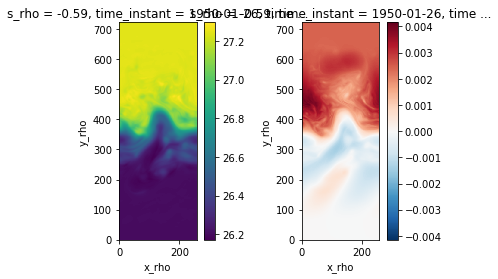

In [11]:
Ti = xr.apply_ufunc(interp2z, zmean, z, T, False, 
                    dask='parallelized', output_dtypes=[np.float64])
Ti = Ti.assign_coords(z_rho=zmean)
print(Ti)

ax = plt.subplot(1,2,1)
Ti.isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')
#
ax = plt.subplot(1,2,2)
(T-Ti).isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')

**Temporal mean of stratification T(x,y,$\bar{z}$,t) -> T(x,y,$\bar{z}$)**

<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(50, 722, 258), dtype=float64, chunksize=(50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho   (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f        (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


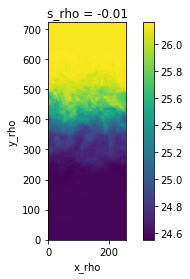

In [12]:
Tmean = Ti.mean(dim='time')
print(Tmean)
p = Tmean.isel(s_rho=-1).plot()
p.axes.set_aspect('equal')

**Compute N2 profile from stratification on mean z  T(x,y,$\bar{z}$) -> N2(x,y,$\bar{z}$)**

<xarray.DataArray (s_w: 51, y_rho: 722, x_rho: 258)>
dask.array<truediv, shape=(51, 722, 258), dtype=float64, chunksize=(49, 722, 258), chunktype=numpy.ndarray>
Dimensions without coordinates: s_w, y_rho, x_rho


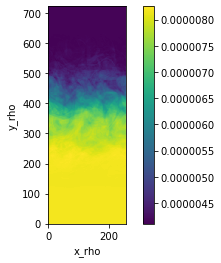

In [13]:
N2 = N2Profile(r,Tmean,zmean)
print(N2)
p = N2.isel(s_w=-1).plot()
p.axes.set_aspect('equal')

**Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)**

In [14]:
import scipy.sparse as sp
import scipy.sparse.linalg as la

def computemodes(zc, zf, N2f, nmodes, free_surf=True, g=9.81, sigma=.1):
    """ compute vertical modes: solution of SL problem (phi'/N^2)'+k*phi=0'
    returns phi at rho points, dphi at w points and c=1/sqrt(k) 
    copy-pasted from M. Dunphy's vmodes.py"""
    debug = False
    # Precompute a few quantities
    #sigma=.1 # shift-invert mode, may want to switch to None
    dzc=np.diff(zc)
    dzf=np.diff(zf)
    Np=len(zf) #self.zf)
    N20=N2f[-1] #self.N2f[-1]  # N^2(z=0)
    H = abs(zf[0])
    if debug:
        print("input shapes:", zc.shape, zf.shape, N2f.shape, flush=True)
    
    # Build Dz, C-to-F grid 
    if False:
        v1=-1.0/np.append(dzc, 1)
        v2= 1.0/np.append(1, dzc)
        v12=np.append([v1],[v2],axis=0)
    else:
        v1=-1.0/np.concatenate([dzf,np.ones(1)])
        v2= 1.0/np.concatenate([np.ones(1),dzf])
        v12=np.stack([v1, v2])
    Dz=sp.spdiags(v12,[-1, 0],Np,Np-1,format="lil")
    # Adjust matrix for BCs
    Dz[0,:]=0
    Dz[-1,:]=0
    if free_surf:
        Dz[-1,-1]=np.divide(-N20, g + N20*(zf[-1] - zc[-1]))

    # Build Dz2, F-to-C grid
    v1=-1.0/np.append(dzf,1)
    v2= 1.0/np.append(1,dzf)
    v12=np.append([v1],[v2],axis=0)
    Dz2=sp.spdiags(v12,[0, 1],Np-1,Np,format="lil")
    if debug: print(v1.shape, v2.shape, v12.shape, Dz2.shape)
    
    # Construct A, solve eigenvalue problem
    iN2=sp.spdiags(1.0/N2f,0,Np,Np)
    A=-Dz2*iN2*Dz
    if debug: print("constructed matrix A with shape", A.shape)
    #ev,ef = la.eigs(A.tocsc(),self.nmodes+1,sigma=0.1)
    ev,ef = la.eigs(A.tocsc(),nmodes+1,sigma=sigma)
    ev,ef = np.real(ev), np.real(ef)
    
    if debug: print("compute eigenmodes with shape", ev.shape, ef.shape, flush=True)
    # Convert eigvenvalues to c_e, sort appropriately
    c=1.0/np.sqrt(np.real(ev))
    ii=(-c).argsort()
    c=c[ii]               # c_e value
    phic=ef[:,ii]         # phi at cell centres

    # Normalize and set surface value positive
    for mi in range(nmodes+1):
        fn=phic[:,mi]        # current phi
        s=np.sign(fn[-1])         # sign at surface
        if s==0:
            s=1;
        tmp = np.sum((fn**2)*dzf)/H
        phic[:,mi] = s*fn/np.sqrt(tmp) # (1/H)*\int_{-H}^{0} \phi_m(z)^2 dz = 1
    if debug: print("sorted and normalized modes with shape", phic.shape, flush=True)
        
    # Verify number of zero crossings matches mode number
    for mi in range(nmodes+1):
        nzc=int(np.sum(np.abs(np.diff(np.sign(phic[:,mi]))))/2.0)
        if mi != nzc:
            print("problem! starting embed() in vmodes._computemodes()")
            embed()
            exit()

    # dphi at cell faces
    dphif=Dz*phic
    if debug: print("checked modes and computed dphi ; now returning results", flush=True)
    return c, phic, dphif

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:109: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


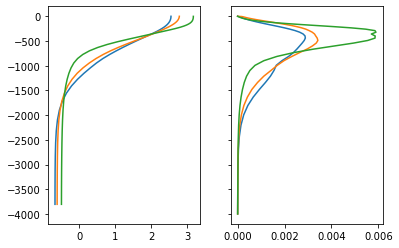

In [15]:
### using apply_ufunc # several points (section at given x)
zwean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='w', hgrid='r')
# NB: z_w does not have s_w coordinate: is it be possible to fix this?

nmodes = 10
jj = 20
zc = zmean.isel(x_rho=jj)
zf = zwean.isel(x_rho=jj)
N2f = N2.isel(x_rho=jj)

res = xr.apply_ufunc(computemodes, zc, zf, N2f, nmodes, 
                     input_core_dims=[["s_rho"],["s_w"],["s_w"],[]], 
                    dask='allowed', output_dtypes=[np.float64,np.float64,np.float64], 
                    output_core_dims=[["modes"],["s_rho","modes"],["s_w","modes"]], 
                    vectorize=True)
# expand result
cn, phin, dphi = res

### PROBLEM: can't assign z_rho, z_w to DataArrays
phin.assign_coords(z_rho=zc)
dphi.assign_coords(z_w=zf)

### plotting results at a few locations in y
inds = [10,360,700] # y indices for plotting
### can't plot using xarray builtins because of missing coord for s_w
fig, axs = plt.subplots(1, 2, sharey=True) # can't sharey because missing coord for s_w
axs[0].plot(phin.sel(modes=1).isel(y_rho=inds).T, zc.isel(y_rho=inds))
axs[1].plot(dphi.sel(modes=1).isel(y_rho=inds).T, zf.isel(y_rho=inds))

#phin.sel(modes=1).isel(x_rho=inds)
#dphi.sel(modes=1).isel(x_rho=[1,10,100]).plot.line(y='s_w', ax=axs[1])

### tries and tribes for v-mode computation and wrapping into xarray

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:109: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


starting now
input shapes: (50,) (51,) (51,)
(51,) (51,) (2, 51) (50, 51)
constructed matrix A with shape (50, 50)
compute eigenmodes with shape (11,) (50, 11)
sorted and normalized modes with shape (50, 11)
checked modes and computed dphi ; now returning results


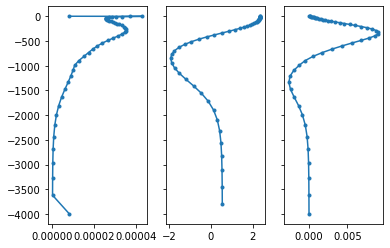

In [116]:
# do it with numpy, just to check that it works -- single x, y point

zwean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='w', hgrid='r')
ix, jy = 20, 20
zr = zmean.isel(y_rho=20,x_rho=20).values
zw = zwean.isel(y_rho=20,x_rho=20).values
bvf = N2.isel(y_rho=20,x_rho=20).values

res = comp_mod(zr, zw, bvf, 10)

### OK, that works
imod = 2
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].plot(bvf, zw, ".-")
axs[1].plot(res[1][:,imod], zr, ".-")
axs[2].plot(res[2][:,imod], zw, '.-')

In [157]:
### using apply_ufunc # single point in x, y
nmodes = 10
ix, jy = 20, 20
zc = zmean.isel(y_rho=jy,x_rho=ix)
zf = zwean.isel(y_rho=jy,x_rho=ix)
N2f = N2.isel(y_rho=jy,x_rho=ix)

res = xr.apply_ufunc(computmodes, zc, zf, N2f, nmodes, 
                     input_core_dims=[["s_rho"],["s_w"],["s_w"],[]], 
                    dask='allowed', output_dtypes=[np.float64,np.float64,np.float64], 
                    output_core_dims=[["modes"],["s_rho","modes"],["s_w","modes"]], 
                    vectorize=True)

### plot result
imod = 2
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].plot(bvf, zw, ".-")
axs[1].plot(res[1][:,imod], zr, ".-")
axs[2].plot(res[2][:,imod], zw, '.-')

NameError: name 'comput_modes' is not defined

# Projection of a variable on vertical modes

**Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)**

In [16]:
### u2rho returns " KeyError: 'X' "
uu = r['his'].u_t_cos.isel(x_u=[jj,jj+1]).mean("x_u")

ui = xr.apply_ufunc(interp2z, zmean, z, uu, False, 
                    dask='parallelized', output_dtypes=[np.float64])

### I need to switch dim from "s_w" to "s_rho" for dz
### same for u, v -> need u2rho, v2rho and have xarray understand y_u = y_rho
un = (zwean.diff('s_w')*ui*phin).sum("s_rho")

**Projection on vertical modes -> $var_{n}$(x,y,t)**